In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import graphviz
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### BÀI TẬP 2.1.3: CÂY QUYẾT ĐỊNH VÀ RỪNG CÂY - DỮ LIỆU TITANIC

#### PHẦN 1: NẠP DỮ LIỆU

In [4]:
print("\n[1] NẠP DỮ LIỆU")
print("-" * 70)

try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print(" Đã nạp dữ liệu thành công!")
except FileNotFoundError:
    print(" Không tìm thấy file dữ liệu")
    print("Vui lòng đảm bảo có file: train.csv, test.csv")
    exit()

print(f"\nKích thước train: {train_df.shape}")
print(f"Kích thước test: {test_df.shape}")
print(f"\nCác cột: {train_df.columns.tolist()}")
print(f"\n5 dòng đầu tiên:")
print(train_df.head())

print(f"\nGiá trị thiếu trong train:")
print(train_df.isnull().sum())

print(f"\nPhân bố nhãn Survived:")
print(train_df['Survived'].value_counts())


[1] NẠP DỮ LIỆU
----------------------------------------------------------------------
 Đã nạp dữ liệu thành công!

Kích thước train: (891, 12)
Kích thước test: (418, 11)

Các cột: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

5 dòng đầu tiên:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   

#### PHẦN 2: TIỀN XỬ LÝ DỮ LIỆU

In [5]:
print("\n[2] TIỀN XỬ LÝ DỮ LIỆU")
print("-" * 70)

def preprocess_data(df):
    """Hàm tiền xử lý dữ liệu"""
    data = df.copy()
    
    # Xử lý Age: điền giá trị trung vị
    data['Age'].fillna(data['Age'].median(), inplace=True)
    
    # Xử lý Embarked: điền mode
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    
    # Xử lý Fare: điền median
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    
    # Tạo feature HasCabin
    data['HasCabin'] = data['Cabin'].notna().astype(int)
    
    # Tạo FamilySize
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    # Tạo IsAlone
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    # Trích xuất Title từ Name
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Nhóm các Title hiếm
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                            'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                            'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
    # Mã hóa Title
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'].fillna(0, inplace=True)
    
    # Mã hóa Sex
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    
    # Mã hóa Embarked
    embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
    data['Embarked'] = data['Embarked'].map(embarked_mapping)
    
    # Tạo bins cho Age
    data['AgeBin'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], 
                            labels=[0, 1, 2, 3, 4])
    
    # Tạo bins cho Fare
    data['FareBin'] = pd.qcut(data['Fare'], q=4, labels=[0, 1, 2, 3], duplicates='drop')
    
    return data

# Tiền xử lý dữ liệu train và test
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)

# Chọn features
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 
            'FamilySize', 'IsAlone', 'HasCabin', 'Title']

X_full = train_processed[features]
y_full = train_processed['Survived']

print(f"\nHoàn thành tiền xử lý!")
print(f"Features: {features}")
print(f"Kích thước X: {X_full.shape}")


[2] TIỀN XỬ LÝ DỮ LIỆU
----------------------------------------------------------------------

Hoàn thành tiền xử lý!
Features: ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'HasCabin', 'Title']
Kích thước X: (891, 9)


#### PHẦN 3: CHIA DỮ LIỆU TRAIN/VALIDATION

In [6]:
print("\n[3] CHIA DỮ LIỆU TRAIN/VALIDATION")
print("-" * 70)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


[3] CHIA DỮ LIỆU TRAIN/VALIDATION
----------------------------------------------------------------------
Train set: (712, 9)
Validation set: (179, 9)


#### PHẦN 4: XÂY DỰNG CÂY QUYẾT ĐỊNH


[4] XÂY DỰNG CÂY QUYẾT ĐỊNH
----------------------------------------------------------------------

4.1. Cây quyết định cơ bản (max_depth=3)
Accuracy trên train: 0.8315
Accuracy trên validation: 0.8324

4.2. Tìm tham số tối ưu với GridSearchCV
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Tham số tốt nhất: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
✓ Accuracy tốt nhất (CV): 0.8175

Accuracy trên train: 0.8315
Accuracy trên validation: 0.8324

4.3. Vẽ biểu đồ ảnh hưởng của max_depth


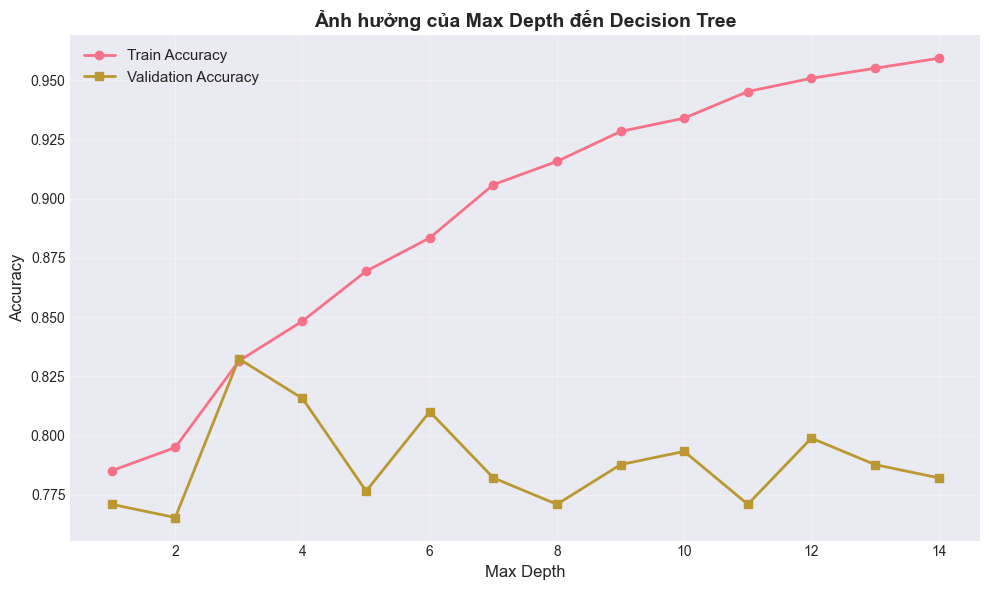

In [7]:
print("\n[4] XÂY DỰNG CÂY QUYẾT ĐỊNH")
print("-" * 70)

# 4.1. Cây đơn giản với max_depth=3
print("\n4.1. Cây quyết định cơ bản (max_depth=3)")
dt_basic = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_basic.fit(X_train, y_train)

train_acc_basic = dt_basic.score(X_train, y_train)
val_acc_basic = dt_basic.score(X_val, y_val)

print(f"Accuracy trên train: {train_acc_basic:.4f}")
print(f"Accuracy trên validation: {val_acc_basic:.4f}")

# 4.2. Tìm max_depth tối ưu bằng GridSearchCV
print("\n4.2. Tìm tham số tối ưu với GridSearchCV")

dt_params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(
    dt, 
    param_grid=dt_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print(f"\n✓ Tham số tốt nhất: {grid_dt.best_params_}")
print(f"✓ Accuracy tốt nhất (CV): {grid_dt.best_score_:.4f}")

# Đánh giá trên validation
best_dt = grid_dt.best_estimator_
train_acc_dt = best_dt.score(X_train, y_train)
val_acc_dt = best_dt.score(X_val, y_val)

print(f"\nAccuracy trên train: {train_acc_dt:.4f}")
print(f"Accuracy trên validation: {val_acc_dt:.4f}")

# 4.3. Vẽ biểu đồ so sánh max_depth
print("\n4.3. Vẽ biểu đồ ảnh hưởng của max_depth")

depths = range(1, 15)
train_scores = []
val_scores = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    train_scores.append(dt_temp.score(X_train, y_train))
    val_scores.append(dt_temp.score(X_val, y_val))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'o-', label='Train Accuracy', linewidth=2)
plt.plot(depths, val_scores, 's-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Ảnh hưởng của Max Depth đến Decision Tree', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### PHẦN 5: XÂY DỰNG RỪNG CÂY (RANDOM FOREST)



[5] XÂY DỰNG RỪNG CÂY (RANDOM FOREST)
----------------------------------------------------------------------

5.1. Random Forest cơ bản (n_estimators=100)
Accuracy trên train: 0.8820
Accuracy trên validation: 0.8156

5.2. Tìm tham số tối ưu cho Random Forest
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✓ Tham số tốt nhất: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
✓ Accuracy tốt nhất (CV): 0.8301

Accuracy trên train: 0.8385
Accuracy trên validation: 0.7989

5.3. Mức độ quan trọng của các features
      Feature  Importance
1         Sex    0.308846
8       Title    0.285162
3        Fare    0.100742
0      Pclass    0.094083
7    HasCabin    0.070677
2         Age    0.063342
5  FamilySize    0.057553
4    Embarked    0.013856
6     IsAlone    0.005739


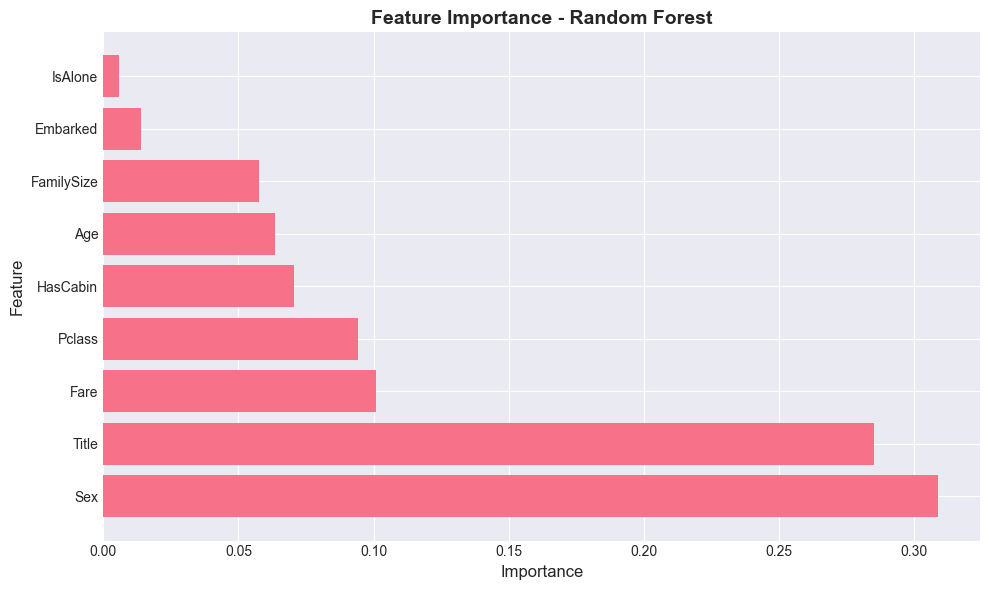


5.4. Vẽ biểu đồ ảnh hưởng của n_estimators


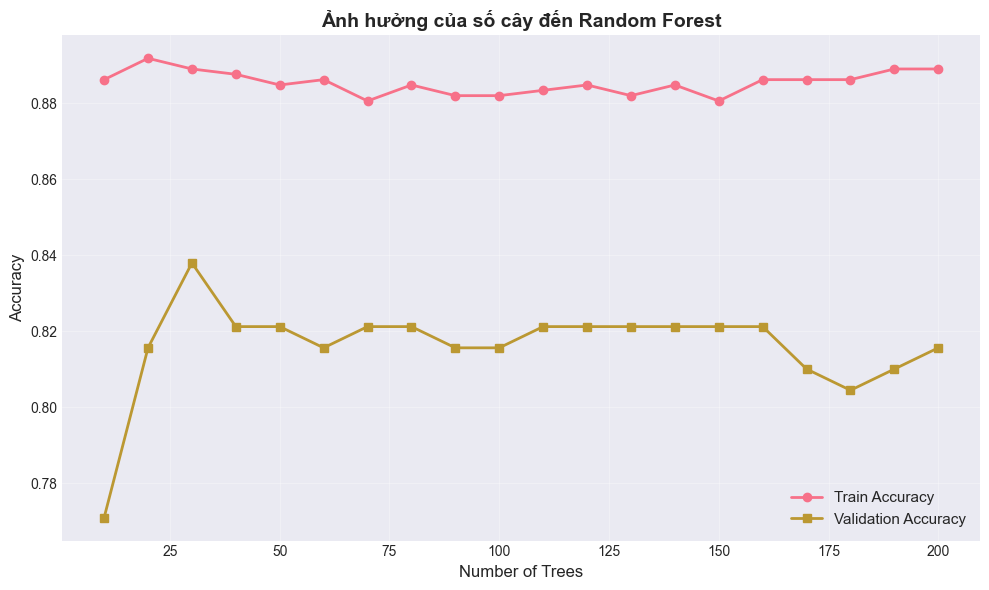

In [9]:
print("\n[5] XÂY DỰNG RỪNG CÂY (RANDOM FOREST)")
print("-" * 70)

# 5.1. Random Forest cơ bản
print("\n5.1. Random Forest cơ bản (n_estimators=100)")

rf_basic = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf_basic.fit(X_train, y_train)

train_acc_rf_basic = rf_basic.score(X_train, y_train)
val_acc_rf_basic = rf_basic.score(X_val, y_val)

print(f"Accuracy trên train: {train_acc_rf_basic:.4f}")
print(f"Accuracy trên validation: {val_acc_rf_basic:.4f}")

# 5.2. Tìm tham số tối ưu
print("\n5.2. Tìm tham số tối ưu cho Random Forest")

rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(
    rf,
    param_grid=rf_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print(f"\n✓ Tham số tốt nhất: {grid_rf.best_params_}")
print(f"✓ Accuracy tốt nhất (CV): {grid_rf.best_score_:.4f}")

# Đánh giá
best_rf = grid_rf.best_estimator_
train_acc_rf = best_rf.score(X_train, y_train)
val_acc_rf = best_rf.score(X_val, y_val)

print(f"\nAccuracy trên train: {train_acc_rf:.4f}")
print(f"Accuracy trên validation: {val_acc_rf:.4f}")

# 5.3. Feature Importance
print("\n5.3. Mức độ quan trọng của các features")

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5.4. Vẽ biểu đồ ảnh hưởng của n_estimators
print("\n5.4. Vẽ biểu đồ ảnh hưởng của n_estimators")

n_trees = range(10, 201, 10)
train_scores_rf = []
val_scores_rf = []

for n in n_trees:
    rf_temp = RandomForestClassifier(n_estimators=n, max_depth=6, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    train_scores_rf.append(rf_temp.score(X_train, y_train))
    val_scores_rf.append(rf_temp.score(X_val, y_val))

plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_scores_rf, 'o-', label='Train Accuracy', linewidth=2)
plt.plot(n_trees, val_scores_rf, 's-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Ảnh hưởng của số cây đến Random Forest', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### PHẦN 6: SO SÁNH CÁC MÔ HÌNH


[6] SO SÁNH KẾT QUẢ CÁC MÔ HÌNH
----------------------------------------------------------------------
                Model  Train Accuracy  Validation Accuracy
Decision Tree (Basic)        0.831461             0.832402
Decision Tree (Tuned)        0.831461             0.832402
Random Forest (Basic)        0.882022             0.815642
Random Forest (Tuned)        0.838483             0.798883

[7] CONFUSION MATRIX - RANDOM FOREST (TUNED)
----------------------------------------------------------------------


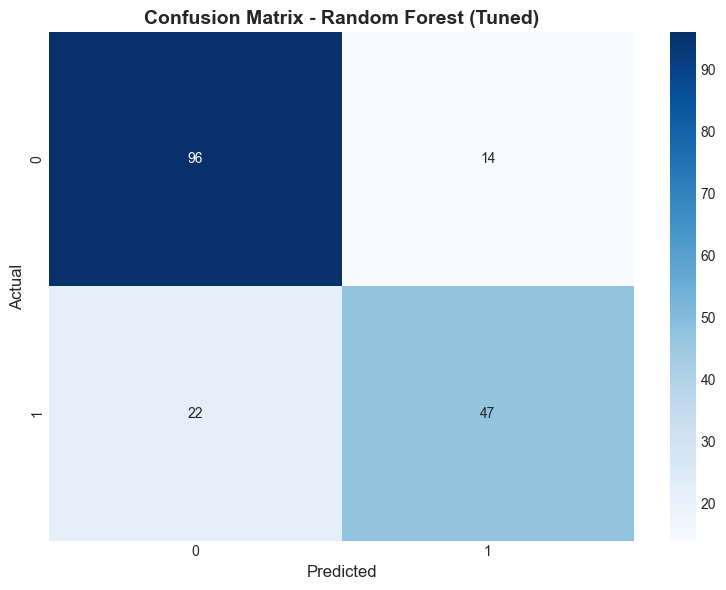


Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.87      0.84       110
    Survived       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



In [10]:
print("\n[6] SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
print("-" * 70)

models_comparison = pd.DataFrame({
    'Model': ['Decision Tree (Basic)', 'Decision Tree (Tuned)', 
              'Random Forest (Basic)', 'Random Forest (Tuned)'],
    'Train Accuracy': [train_acc_basic, train_acc_dt, train_acc_rf_basic, train_acc_rf],
    'Validation Accuracy': [val_acc_basic, val_acc_dt, val_acc_rf_basic, val_acc_rf]
})

print(models_comparison.to_string(index=False))

# Confusion Matrix cho mô hình tốt nhất
print("\n[7] CONFUSION MATRIX - RANDOM FOREST (TUNED)")
print("-" * 70)

y_pred = best_rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Random Forest (Tuned)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
